In [11]:
import pandas as pd
import numpy as np
import re
import nltk

# For text preprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# For vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# For model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from textblob import TextBlob


# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack


# Download NLTK data files (only the first time)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/malfridurannaeiriksdottir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/malfridurannaeiriksdottir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/malfridurannaeiriksdottir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv('../data/akereviewsdataset.csv')

In [3]:
# Encode labels: 'cg' -> 1, 'or' -> 0
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Check label encoding
print(label_encoder.classes_)  # Should output: array(['CG', 'OR'])


['CG' 'OR']


In [4]:
# Check for missing values
print(df.isnull().sum())

# If there are missing values in 'text_' or 'label_encoded', drop those rows
df = df.dropna(subset=['text_', 'label_encoded'])


category         0
rating           0
label            0
text_            0
label_encoded    0
dtype: int64


In [5]:
# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    words = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join back into a string
    return ' '.join(words)

# Apply preprocessing
df['clean_text'] = df['text_'].apply(preprocess_text)


In [8]:
# Assuming these columns exist in your DataFrame
numerical_features = ['sentiment_score', 'text_length', 'rating_deviation']

In [9]:
df['text_length'] = df['text_'].str.len()

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply the function to the 'text_' column
df['sentiment_score'] = df['text_'].apply(get_sentiment)

mean_rating = df['rating'].mean()
df['rating_deviation'] = df['rating'] - mean_rating


In [10]:
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust 'max_features' as needed
X_text = vectorizer.fit_transform(df['clean_text'])


In [15]:

scaler = StandardScaler()
X_num = scaler.fit_transform(df[numerical_features])

from scipy import sparse
X_num_sparse = sparse.csr_matrix(X_num)


X = hstack([X_text, X_num_sparse])
y = df['label_encoded']

# Logistic regression

In [16]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [17]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [18]:
# Predict on the test set
y_pred = model.predict(X_test)


Accuracy: 0.8417
Classification Report:
              precision    recall  f1-score   support

          CG       0.84      0.84      0.84      4044
          OR       0.84      0.84      0.84      4043

    accuracy                           0.84      8087
   macro avg       0.84      0.84      0.84      8087
weighted avg       0.84      0.84      0.84      8087



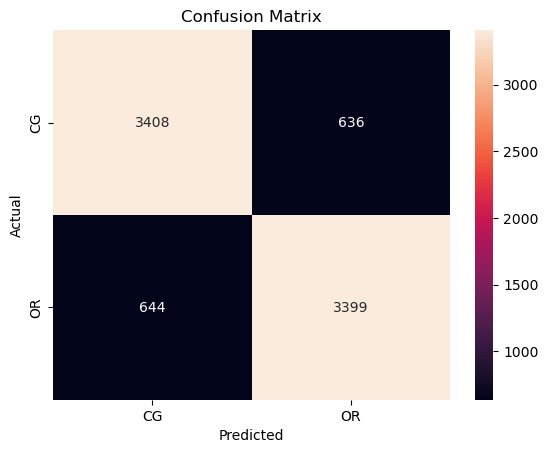

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [20]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()
# Append numerical feature names
feature_names = np.concatenate([feature_names, numerical_features])

# Get coefficients
coefficients = model.coef_[0]

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Top positive coefficients
top_positive = coef_df.sort_values(by='coefficient', ascending=False).head(10)
print('Top Positive Features:')
print(top_positive)

# Top negative coefficients
top_negative = coef_df.sort_values(by='coefficient').head(10)
print('Top Negative Features:')
print(top_negative)


Top Positive Features:
      feature  coefficient
250      even     5.885921
968   without     4.843706
866    though     4.686699
403   however     4.425591
971      wont     3.914402
6    actually     3.788638
25   although     3.724130
543      much     3.596187
424   instead     3.545975
237       end     3.440222
Top Negative Features:
       feature  coefficient
688     reason    -6.008347
652    problem    -5.406748
699    replace    -5.253970
199  developed    -5.091471
13       admit    -5.078986
434        iti    -4.923380
216   downside    -4.904322
962       wide    -4.478482
176     couple    -4.421319
623    plastic    -3.859166


# other methods

In [21]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Evaluate SVM model
print('SVM Classification Report:')
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))


/Users/malfridurannaeiriksdottir/anaconda3/envs/myMLvenv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


SVM Classification Report:
              precision    recall  f1-score   support

          CG       0.84      0.84      0.84      4044
          OR       0.84      0.84      0.84      4043

    accuracy                           0.84      8087
   macro avg       0.84      0.84      0.84      8087
weighted avg       0.84      0.84      0.84      8087



In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest model
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))


Random Forest Classification Report:
              precision    recall  f1-score   support

          CG       0.84      0.86      0.85      4044
          OR       0.85      0.83      0.84      4043

    accuracy                           0.84      8087
   macro avg       0.84      0.84      0.84      8087
weighted avg       0.84      0.84      0.84      8087



In [23]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print('Best Parameters:', grid.best_params_)

# Use the best estimator
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
print('Best Model Classification Report:')
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))


Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Model Classification Report:
              precision    recall  f1-score   support

          CG       0.84      0.84      0.84      4044
          OR       0.84      0.84      0.84      4043

    accuracy                           0.84      8087
   macro avg       0.84      0.84      0.84      8087
weighted avg       0.84      0.84      0.84      8087

